# 15. 텐서보드(TensorBoard) 활용

## 15.1 그래프 그리기

In [1]:
import shutil
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

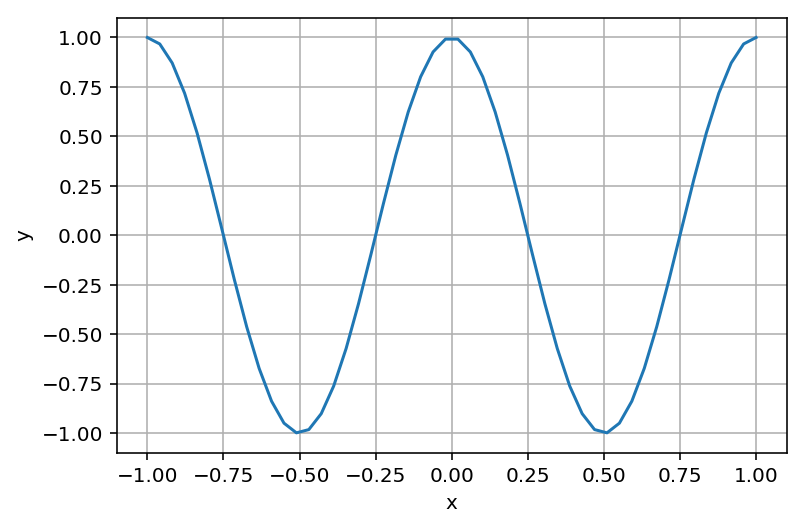

In [2]:
x = np.linspace(-1, 1)
y  = np.cos(2 * np.pi * x)
plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
x = tf.placeholder(tf.float32)
y = tf.cos(2*np.pi*x)

logs_path = './001_scalar/'
tf.summary.scalar("Cosine", y)
merged_summary_op = tf.summary.merge_all()
scalar_summary_filewriter = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

In [4]:
domain = np.linspace(-1,1)
sess = tf.Session()
for k in range(len(domain)):
    summary = sess.run(merged_summary_op, feed_dict={x: domain[k]})
    scalar_summary_filewriter.add_summary(summary, k)

## 15.2 히스토그램 그리기

In [5]:
tf.reset_default_graph()

logs_path = './002_histogram/'
mu = tf.placeholder(tf.float32)
normal_dist = tf.random_normal(shape=[1000], mean = mu, stddev=1)
tf.summary.histogram("Normal_Distribution", normal_dist)
merged_summary_op = tf.summary.merge_all()
histogram_summary_filewriter = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

In [6]:
sess = tf.Session()
N = 400
for k in range(N):
    mu_val = k / float(N)
    summary = sess.run(merged_summary_op, feed_dict={mu: mu_val})
    histogram_summary_filewriter.add_summary(summary, k)

## 15.3 이미지 그리기

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
tf.reset_default_graph()
logs_path = './003_image/'

x = tf.placeholder(tf.float32, [784])
tf.summary.image("Image", tf.reshape(x, [-1, 28, 28, 1]))
merged_summary_op = tf.summary.merge_all()
image_summary_filewriter = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

In [9]:
sess = tf.Session()
N = 400
for k in range(N):
    anImage = mnist.train.images[k]
    summary = sess.run(merged_summary_op, feed_dict={x:anImage})
    image_summary_filewriter.add_summary(summary, k)

In [10]:
plt.rcParams['figure.figsize'] = (16./3, 9./3)

def plot_model(sess, model, xy, labels, xy_test, labels_test, feature_lambda, title=''):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.2,1.2,400), np.linspace(-1.2,1.2,400))
    prediction = sess.run(model, feed_dict={x: np.array([feature_lambda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])})
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='k')
        
    df = DataFrame(dict(x=xy_test[:,0], y=xy_test[:,1], label=labels_test.flatten()))
    markers = {0:'bs', 1:'r^'}
    cs = ax.contourf(xx, yy, Z, 20, cmap='coolwarm', alpha=.9)
    ax.clabel(cs, colors='gray')
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='none')
        
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(title)
    plt.show()

## 15.4 신경망 모델 학습 과정에 텐서보드 적용하기

In [11]:
from sklearn.datasets import make_circles
import os

tf.reset_default_graph()

# 학습용 데이터 생성
xy_train, labels_train = make_circles(n_samples=50, noise=0.1, random_state=717)
labels_train = labels_train.reshape(-1,1)

# 테스트용 데이터 생성
xy_test, labels_test = make_circles(n_samples=50, noise=0.1, random_state=712)
labels_test = labels_test.reshape(-1,1)

# 특성값 추출
f_fn = lambda x,y: [x, y]
features = np.array([f_fn(xval, yval) for xval, yval in xy_train])
features_test = np.array([f_fn(xval, yval) for xval, yval in xy_test])
dim_features = features.shape[1]

# 은닉층의 노드개수
num_hidden1 = 10
num_hidden2 = 5

# 입력층
x = tf.placeholder(tf.float32, shape=(None, dim_features))

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=tf.random_normal_initializer(seed=624),
                                          biases_initializer=tf.random_normal_initializer(seed=624))

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=tf.random_normal_initializer(seed=624),
                                          biases_initializer=tf.random_normal_initializer(seed=624))

# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=tf.random_normal_initializer(seed=624),
                                          biases_initializer=tf.random_normal_initializer(seed=624))

# 손실함수
y = tf.placeholder(tf.float32, shape=(None, 1))
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat))

# 정확도
correct_prediction = tf.equal(y, tf.round(yhat))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

logs_path = '004_NN_by_Epoch'
tf.summary.scalar("Cross-Entropy_by_batch", loss)
tf.summary.scalar("Accuracy_by_batch", accuracy)
merged_summary_op = tf.summary.merge_all()
train_summary_filewriter = tf.summary.FileWriter(os.path.join(logs_path, 'train'), graph=tf.get_default_graph())
test_summary_filewriter = tf.summary.FileWriter(os.path.join(logs_path, 'test'), graph=tf.get_default_graph())

# 수치최적화 알고리즘
lr = 0.5
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
# 데이터 섞기
np.random.seed(7382)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels_train[idx]

# Log Step
it = 0

# 스토캐스틱 방법
MaxEpochs = 4000
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(MaxEpochs+1):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch.reshape(-1,1)})
    
    # 학습용 데이터를 이용한 손실함수와 정확도 기록
    summ_train = sess.run(merged_summary_op, feed_dict={x: features, y: labels_train.reshape(-1,1)})
    train_summary_filewriter.add_summary(summ_train, it)
    
    # 테스트용 데이터를 이용한 손실함수와 정확도 기록
    summ_test = sess.run(merged_summary_op, feed_dict={x: features_test, y: labels_test.reshape(-1,1)})
    test_summary_filewriter.add_summary(summ_test, it)
    
    # Update Log Step
    it+=1